# CS329E Term Project (Group 6)

Aurea Le (akl2498) and Austin Dornak (amd6583)

## Project Description

The dataset used in this study is sourced from E. Fehrman, A. K. Muhammad, E. M. Mirkes, V. Egan, and A. N. Gorban in their work titled "The Five Factor Model of Personality and Evaluation of Drug Consumption Risk." It comprises responses from 1885 participants, each described by 12 attributes: the NEO-FFI-R personality traits (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), BIS-11 (impulsivity), ImpSS (sensation seeking), level of education, age, gender, country of residence, and ethnicity. Additionally, participants provided self-reported data on their usage of 18 legal and illegal substances. This project aims to apply data analysis and machine learning techniques to explore potential relationships between drug consumption patterns and external factors such as personality traits and demographic characteristics.


## Problem Statement:

We aim to investigate which personality traits (e.g., Neuroticism, Extraversion, Impulsivity, Sensation Seeking) serve as the strongest predictors of drug use across a variety of substances. By exploring this relationship, we hope to uncover how different psychological and demographic factors contribute to patterns of substance use.

To address this question, we will employ a range of data analysis and machine learning techniques. Our approach includes the use of supervised learning models, particularly Random Forests and Gradient Boosting Machines, due to their ability to provide insights into feature importance. Random Forests will help us identify which features are most influential in predicting usage for specific drugs by averaging the results over multiple decision trees to reduce variance and overfitting. Gradient Boosting will allow us to fine tune predictions by minimizing errors and improving weak learners with each iteration.

We predict that personality traits are likely to be meaningful, but NOT sole predictors of drug usage; the subjective nature of human behavior and the complex patterns of drug use may skew the accuracy of our predictions.


## Modeling:

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# fetch dataset 
drug_consumption_quantified = fetch_ucirepo(id=373) 

# data (as pandas dataframes) 
X = drug_consumption_quantified.data.features 
y = drug_consumption_quantified.data.targets 
  
df = drug_consumption_quantified.data.original

In [4]:
df.columns

Index(['id', 'age', 'gender', 'education', 'country', 'ethnicity', 'nscore',
       'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss', 'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'semer', 'vsa'],
      dtype='object')

#### Preprocess Data

We will rebin our data from 7 (CL0, CL1, CL2, CL3, CL4, CL5, CL6) bins into 3 broader categories (low, medium, high). This will simplify the classification task by balancing class distributions.

Additionally, the distribution of users across the various drugs is imbalanced. We need to adjust the sampling of our users in order to account for this. We will employ techniques such as SMOTE (Synthetic Minority Over-sampling Technique), in which samples of minority classes are generated to make the class distribution balanced. By doing this, we can compensate for underrepresented groups.

In [5]:
# Rebin the alcohol classes (CL0-CL6) for more accuracy in our models; reduces label noise
def rebin(cl):
    if cl in ['CL0', 'CL1', 'CL2']:
        return 'low'
    elif cl in ['CL3', 'CL4']:
        return 'medium'
    else:  # CL5 or CL6
        return 'high'

#### Demographic Visualization

It is important to understand the demographic distribution of our dataset, as demographic variables can significantly influence patterns of drug consumption and may introduce biases or confounding factors into our model predictions. By exploring demographics like age, gender, education, and ethnicity, we can identify potential correlations between certain groups and substance use. 

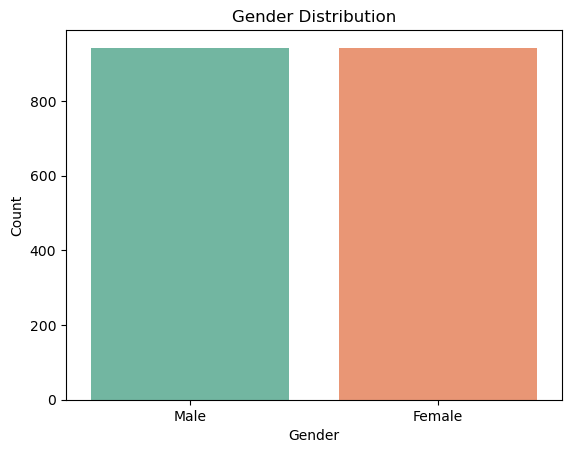

In [34]:
#histogram of gender
genderMap = {0.48246: 'Male', -0.48246: 'Female'}
df['genderLabel'] = df['gender'].map(genderMap)

sns.countplot(data=df, x='genderLabel', hue='genderLabel', palette='Set2', legend=False)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

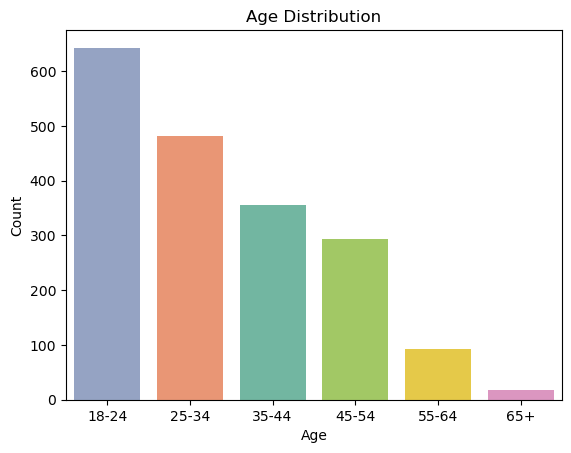

In [37]:
#histogram of age distribution
ageMap = {-0.95197: '18-24', -0.07854: '25-34', 0.49788: '35-44', 1.09449: '45-54', 1.82213: '55-64', 2.59171: '65+'}
df['ages'] = df['age'].map(ageMap)

sns.countplot(data=df, x='ages', hue='ages', order=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], palette='Set2', legend=False)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

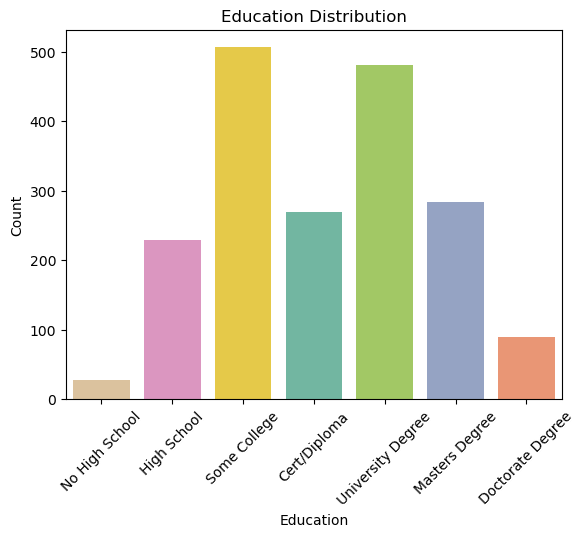

In [74]:
#education
educationMap = {-2.43591: 'No High School',
    -1.73790: 'High School',
    -1.43719: 'High School',
    -1.22751: 'High School',
    -0.61113: 'Some College',
    -0.05921: 'Cert/Diploma',
    0.45468: 'University Degree',
    1.16365: 'Masters Degree',
    1.98437: 'Doctorate Degree'}
df['educationLvl'] = df['education'].map(educationMap)

sns.countplot(data=df, x='educationLvl', order=['No High School', 'High School', 'Some College', 'Cert/Diploma', 'University Degree', 'Masters Degree', 'Doctorate Degree'], hue='educationLvl', palette='Set2', legend=False)
plt.xticks(rotation=45)
plt.title('Education Distribution')
plt.xlabel('Education')
plt.ylabel('Count')
plt.show()

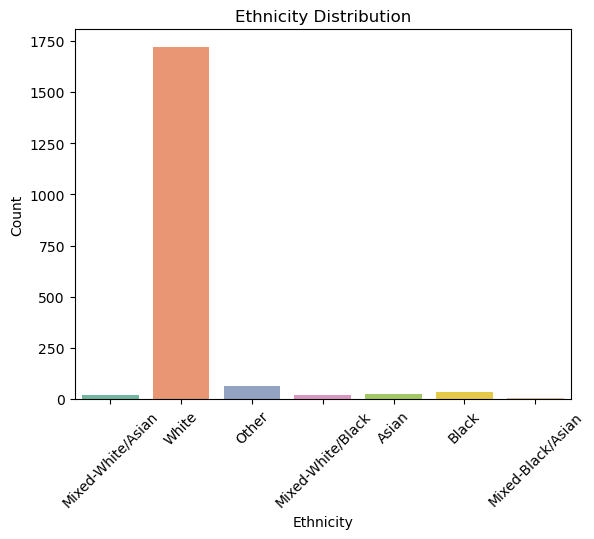

In [ ]:
#ethnicity
ethnicityMap = {-0.50212: 'Asian', -1.10702: 'Black', 1.90725: 'Mixed-Black/Asian', 0.12600: 'Mixed-White/Asian', -0.22166: 'Mixed-White/Black', 0.11440: 'Other', -0.31685: 'White'}
df['ethnicities'] = df['ethnicity'].map(ethnicityMap)

sns.countplot(data=df, x='ethnicities', hue='ethnicities', palette='Set2', legend=False)
plt.xticks(rotation=45)
plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.show()

#### Substance Distribution Visualization

We visualized the bin distribution for alcohol, caffeine, and heroin. Doing this helps us understand the overall patterns of substance use in the population, identify potential class imbalances for model training, and observe how usage frequency is distributed across the sample for each substance.

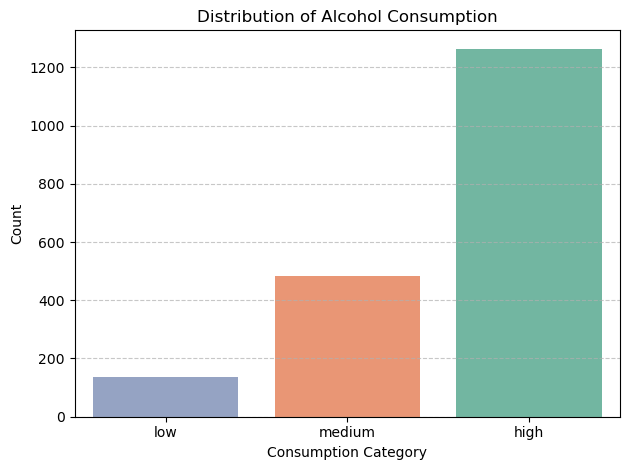

In [48]:
# Consumption distribution for Alcohol
df['alcohol_rebinned'] = df['alcohol'].apply(rebin)
sns.countplot(data=df, x='alcohol_rebinned', hue = 'alcohol_rebinned', order=['low', 'medium', 'high'], palette='Set2')

plt.title('Distribution of Alcohol Consumption')
plt.xlabel('Consumption Category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

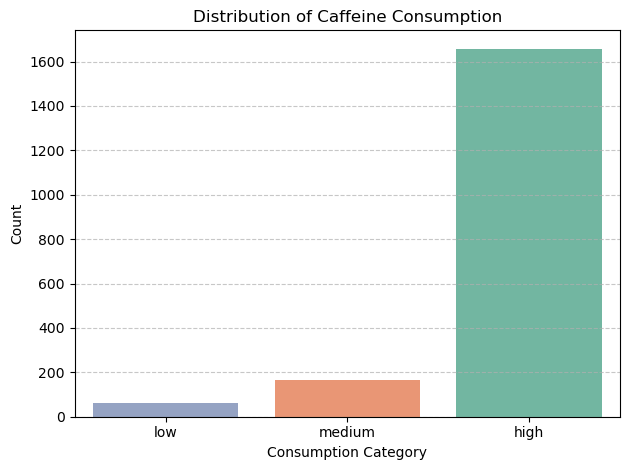

In [50]:
# Consumption distribution for Caffeine
df['caffeine_rebinned'] = df['caff'].apply(rebin)
sns.countplot(data=df, x='caffeine_rebinned', hue = 'caffeine_rebinned', order=['low', 'medium', 'high'], palette='Set2')

plt.title('Distribution of Caffeine Consumption')
plt.xlabel('Consumption Category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

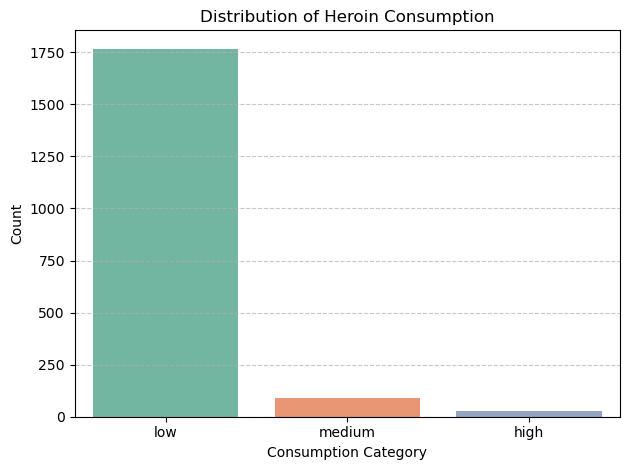

In [51]:
# Consumption distribution for Heroin
df['heroin_rebinned'] = df['heroin'].apply(rebin)
sns.countplot(data=df, x='heroin_rebinned', hue = 'heroin_rebinned', order=['low', 'medium', 'high'], palette='Set2')

plt.title('Distribution of Heroin Consumption')
plt.xlabel('Consumption Category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [52]:
#SMOTE: generate samples of generating samples of minority classes to make the class distribution balanced
# identify minority class instances --> identifies its k nearest neighbors in the feature space --> randomly selects one of neighbors 
# --> generates synthetic samples along the line segment to join minority class instance and the selected nearest neighbor in the
# feature space --> generates synthetic samples until the minority class reaches the same size as the majority class

from imblearn.over_sampling import SMOTE

#split data
y_single = y['alcohol']
y_rebinned = y_single.apply(rebin)
X_j = df[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']]
# neuroticism, extroversion, openess, agreebleness, Conscientiousness, sensation seeking

X_train, X_test, y_train, y_test = train_test_split(X_j, y_rebinned, test_size=0.2, stratify=y_rebinned, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#apply smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

#### Sample Implementations of Random Forest Focused on Different Drugs (Alcohol, Caffeine, Heroin)

#### Alcohol

[0.10558086 0.03111779 0.09493387 0.05103335 0.03566421 0.09476818
 0.10511871 0.10842656 0.09702902 0.10334345 0.07736328 0.09562071]


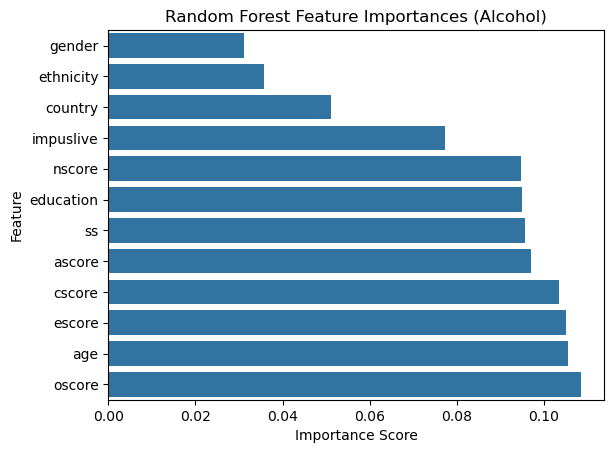

In [9]:
#alcohol

rf_model = RandomForestClassifier(n_estimators=100, random_state=42) #train model
rf_model.fit(X_resampled, y_resampled)

y_pred = rf_model.predict(X_test_scaled)

#feature evaluation
print(rf_model.feature_importances_)

######
feature = X_j.columns
importance = rf_model.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': feature,'Importance': importance}).sort_values(by='Importance', ascending=True)

sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Random Forest Feature Importances (Alcohol)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#### Confusion Matrix For Random Forest Classifier

A confusion matrix was used to provide a summary of the Random Forest Classifier prediction results. Each cell in the matrix displays how often a specific actual class was predicted as another class.

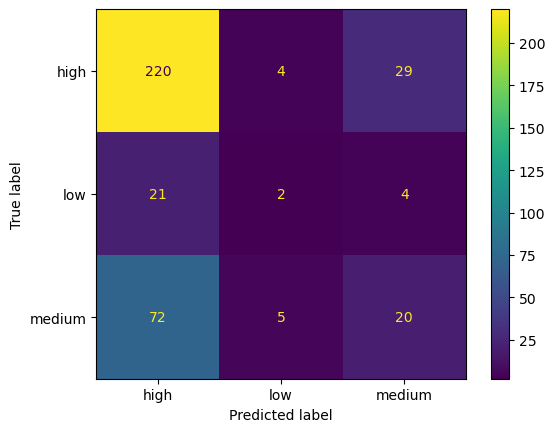

              precision    recall  f1-score   support

        high       0.70      0.87      0.78       253
         low       0.18      0.07      0.11        27
      medium       0.38      0.21      0.27        97

    accuracy                           0.64       377
   macro avg       0.42      0.38      0.38       377
weighted avg       0.58      0.64      0.60       377



In [10]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, target_names=rf_model.classes_))

In a Random Forest implementation focused on alcohol, the model correctly predicts about 64% of the test cases. From the feature importance function, we can infer that openess (oscore), age, agreeableness (ascore), conscientiousness (cscore), and extroversion (escore) all carry strong predictive weight, with each being >10%.

#### Caffeine

[0.10284714 0.03682403 0.08134702 0.04781049 0.04542456 0.08527706
 0.09885928 0.09746925 0.09629269 0.08993715 0.09940614 0.11850519]


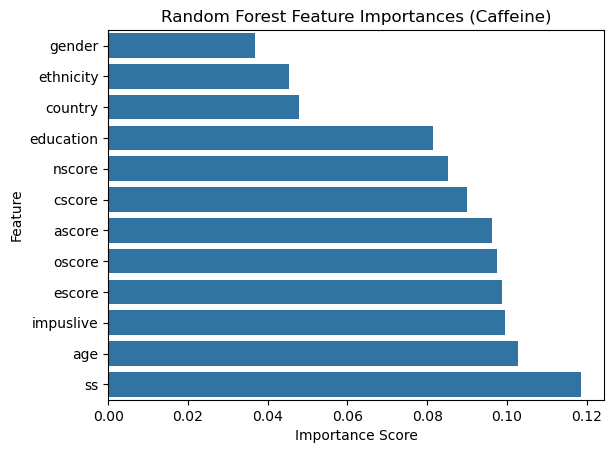

In [11]:
# Example of Random Forest implementation focused on caffeine
y_single = y['caff']
y_rebinned = y_single.apply(rebin)
X_j = df[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']]

X_train, X_test, y_train, y_test = train_test_split(X_j, y_rebinned, test_size=0.2, stratify=y_rebinned, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#apply smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42) #train model
rf_model.fit(X_resampled, y_resampled)

y_pred = rf_model.predict(X_test_scaled)

#evaluation
print(rf_model.feature_importances_)

######
feature = X_j.columns
importance = rf_model.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': feature,'Importance': importance}).sort_values(by='Importance', ascending=True)

sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Random Forest Feature Importances (Caffeine)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#### Confusion Matrix For Caffeine Random Forest Classifier

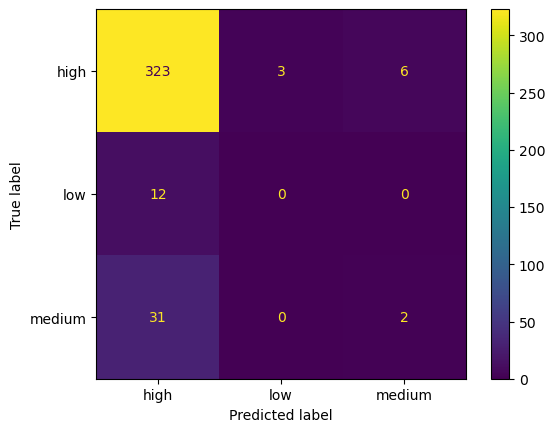

              precision    recall  f1-score   support

        high       0.88      0.97      0.93       332
         low       0.00      0.00      0.00        12
      medium       0.25      0.06      0.10        33

    accuracy                           0.86       377
   macro avg       0.38      0.34      0.34       377
weighted avg       0.80      0.86      0.82       377



In [12]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred, target_names=rf_model.classes_))

In a Random Forest implementation focused on caffeine, the model correctly predicts about 86% of the test cases. From the feature importance function, we can infer that sensation seeking (ss) and age all carry strong predictive weight, with each being >10%.

#### Heroin

[0.09145231 0.04978999 0.07003341 0.12813773 0.01330736 0.10679722
 0.07876727 0.07852496 0.07688981 0.08611771 0.12638335 0.0937989 ]


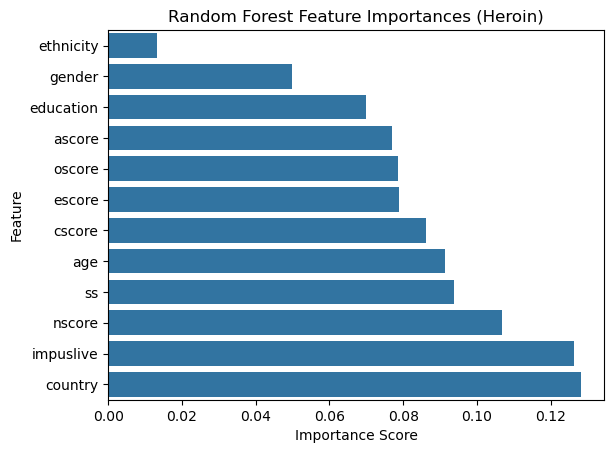

In [13]:
# Example of Random Forest implementation focused on heroin
y_single = y['heroin']
y_rebinned = y_single.apply(rebin)
X_j = df[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']]

X_train, X_test, y_train, y_test = train_test_split(X_j, y_rebinned, test_size=0.2, stratify=y_rebinned, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#apply smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42) #train model
rf_model.fit(X_resampled, y_resampled)

y_pred = rf_model.predict(X_test_scaled)

#evaluation
print(rf_model.feature_importances_)

######
feature = X_j.columns
importance = rf_model.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': feature,'Importance': importance}).sort_values(by='Importance', ascending=True)

sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Random Forest Feature Importances (Heroin)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#### Confusion Matrix For Heroin Random Forest Classifier

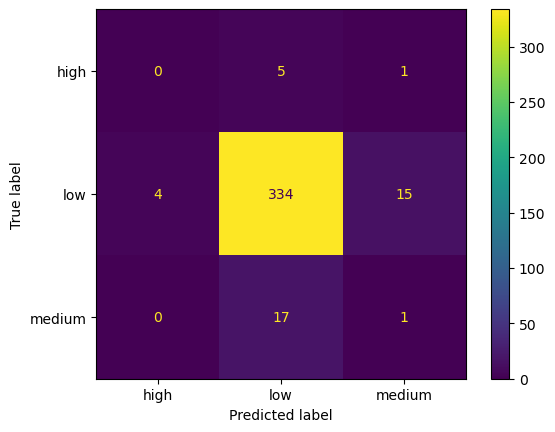

              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.94      0.95      0.94       353
      medium       0.06      0.06      0.06        18

    accuracy                           0.89       377
   macro avg       0.33      0.33      0.33       377
weighted avg       0.88      0.89      0.88       377



In [14]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred, target_names=rf_model.classes_))

In a Random Forest implementation focused on heroin, the model correctly predicts about 89% of the test cases. From the feature importance function, we can infer that country, impulsivity, and neuroticism (nscore) all carry strong predictive weight, with each being >10%.

#### Sample Implementations of Gradient Boost Focused on Different Drugs (Alcohol, Caffeine, Heroin)

#### Alcohol

Accuracy: 0.6339522546419099
[0.09145231 0.04978999 0.07003341 0.12813773 0.01330736 0.10679722
 0.07876727 0.07852496 0.07688981 0.08611771 0.12638335 0.0937989 ]


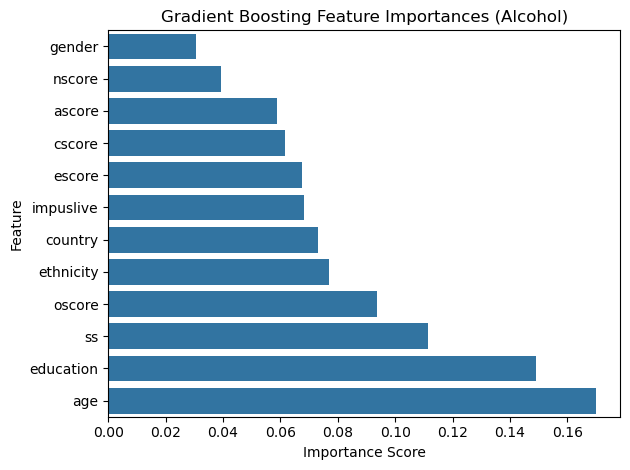

In [15]:
# Import Gradient Boosting Libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

y_single = y['alcohol']
y_rebinned = y_single.apply(rebin)
X_j = df[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']]

X_train, X_test, y_train, y_test = train_test_split(X_j, y_rebinned, test_size=0.2, stratify=y_rebinned, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#apply smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

#train the Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100,    # number of boosting rounds
    learning_rate=0.1,   # how much each tree contributes
    max_depth=3,         # limits complexity of trees
    random_state=42
)

gb_model.fit(X_resampled, y_resampled)

y_pred = gb_model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(rf_model.feature_importances_)

######
feature = X_j.columns
importance = gb_model.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': feature,'Importance': importance}).sort_values(by='Importance', ascending=True)

sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Gradient Boosting Feature Importances (Alcohol)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Confusion Matrix For Alcohol Gradient Boost Classifier

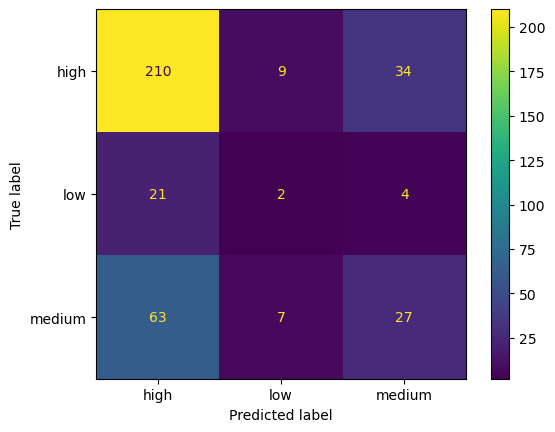

              precision    recall  f1-score   support

        high       0.71      0.83      0.77       253
         low       0.11      0.07      0.09        27
      medium       0.42      0.28      0.33        97

    accuracy                           0.63       377
   macro avg       0.41      0.39      0.40       377
weighted avg       0.59      0.63      0.61       377



In [16]:
# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=gb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_model.classes_)
disp.plot()
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=gb_model.classes_))

Using Gradient Boost, we achieved a 63.4% accuracy for prediciting alochol use. It is only a little less than the prediction power of Random Forest. The top influencing factors are age, education, and sensation seeking. Alcohol use is prohibited until 21 in the US, and other countries have similar restrictions. This could explain its high predictive weight on alcohol use. Although the chart shows a larger influence of age, it is important to notw that Openess still has a similar predictive weight (<0.1) as in our Random Forest model (>0.1).

#### Caffeine

Accuracy: 0.8355437665782494
[0.09145231 0.04978999 0.07003341 0.12813773 0.01330736 0.10679722
 0.07876727 0.07852496 0.07688981 0.08611771 0.12638335 0.0937989 ]


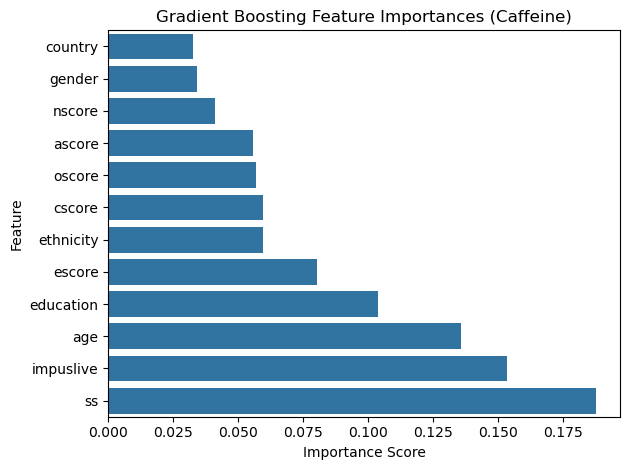

In [17]:
y_single = y['caff']
y_rebinned = y_single.apply(rebin)
X_j = df[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']]

X_train, X_test, y_train, y_test = train_test_split(X_j, y_rebinned, test_size=0.2, stratify=y_rebinned, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#apply smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,   
    max_depth=3,         
    random_state=42
)

gb_model.fit(X_resampled, y_resampled)

y_pred = gb_model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(rf_model.feature_importances_)

######
feature = X_j.columns
importance = gb_model.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': feature,'Importance': importance}).sort_values(by='Importance', ascending=True)

sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Gradient Boosting Feature Importances (Caffeine)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Confusion Matrix For Caffeine Gradient Boost Classifier

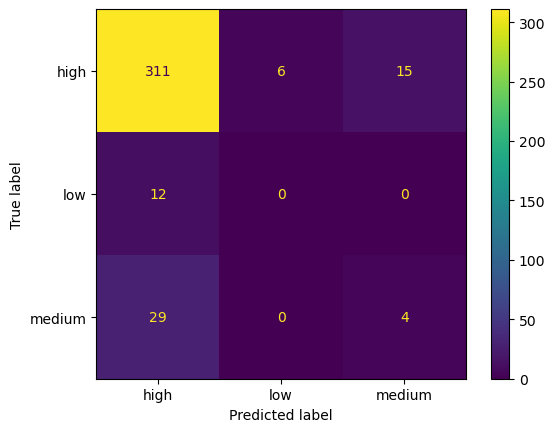

              precision    recall  f1-score   support

        high       0.88      0.94      0.91       332
         low       0.00      0.00      0.00        12
      medium       0.21      0.12      0.15        33

    accuracy                           0.84       377
   macro avg       0.36      0.35      0.35       377
weighted avg       0.80      0.84      0.81       377



In [18]:
# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=gb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_model.classes_)
disp.plot()
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=gb_model.classes_))

Using Gradient Boost, we recorded a decrease in accuracy which is now 83.6% of cases. The top influencing factors for caffiene use are sensation seeking, implusivity, and age. These are the same features that we predicted using Random Forest. 

#### Heroin

Accuracy: 0.8647214854111406
[0.09145231 0.04978999 0.07003341 0.12813773 0.01330736 0.10679722
 0.07876727 0.07852496 0.07688981 0.08611771 0.12638335 0.0937989 ]


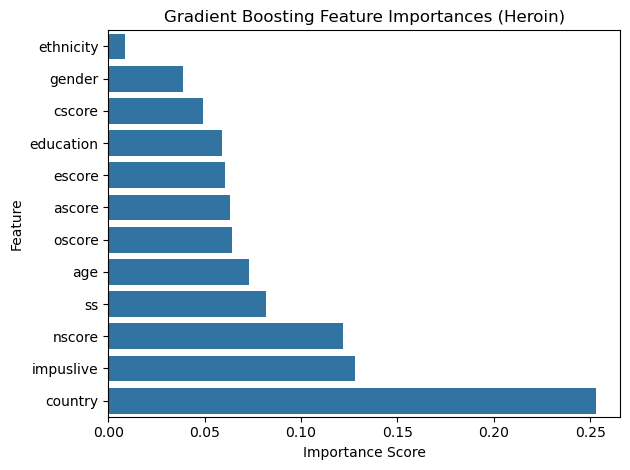

In [19]:
y_single = y['heroin']
y_rebinned = y_single.apply(rebin)
X_j = df[['age', 'gender', 'education', 'country', 'ethnicity', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']]

X_train, X_test, y_train, y_test = train_test_split(X_j, y_rebinned, test_size=0.2, stratify=y_rebinned, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#apply smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,   
    max_depth=3,         
    random_state=42
)

gb_model.fit(X_resampled, y_resampled)

y_pred = gb_model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(rf_model.feature_importances_)

######
feature = X_j.columns
importance = gb_model.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': feature,'Importance': importance}).sort_values(by='Importance', ascending=True)

sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Gradient Boosting Feature Importances (Heroin)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Confusion Matrix For Heroin Gradient Boost Classifier

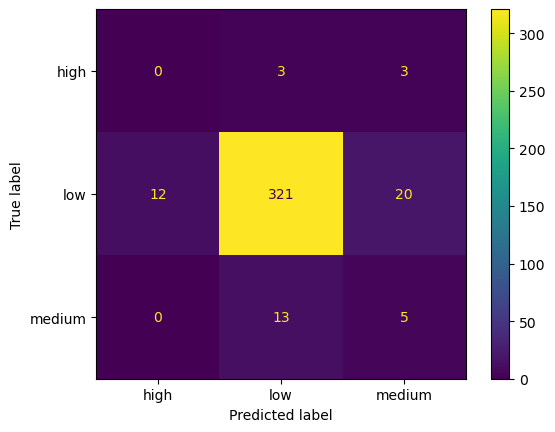

              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.95      0.91      0.93       353
      medium       0.18      0.28      0.22        18

    accuracy                           0.86       377
   macro avg       0.38      0.40      0.38       377
weighted avg       0.90      0.86      0.88       377



In [20]:
# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=gb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_model.classes_)
disp.plot()
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=gb_model.classes_))

The accuracy of the Gradient Boost model is 86.5% percent. As we saw in Random Forest predictions, country has the largest impact on heroin usage. Impulsivity and Neuroticism are also important factors with a predictive weight >10%. Although country has the highest influence, ethnicity has the lowest. This could be a result of legal restrictions on heroin use in countries such as the USA. 

## Result Interpretations
After training and evaluating both Random Forest and Gradient Boosting models on three different drug categories (Alcohol, Caffeine, and Heroin) several trends emerged in the feature importance rankings:

Personality traits such as Neuroticism (nscore), Agreeableness (ascore), and Conscientiousness (cscore) were consistently among the most important predictors across all three substances. These results strongly support the psychological literature, particularly Fehrman et al.'s findings that individuals who engage in substance use often exhibit higher levels of Neuroticism and lower levels of Agreeableness and Conscientiousness.

Impulsivity (impuslive) and Sensation Seeking (ss) also ranked highly, particularly for Heroin, suggesting that more extreme behavioral traits play a bigger role in predicting usage of harder substances.

Extraversion (escore) and Openness to Experience (oscore) were moderately important, with more impact seen in predictions for Alcohol and Caffeine, potentially reflecting the social or experimental aspects of these substances.

Demographic variables such as Gender and Ethnicity consistently showed the lowest importance scores across all three drugs. This suggests that these features do not significantly influence the model's predictions and are likely poor standalone predictors of substance use in this dataset.

In summary, the models confirm that internal personality and behavioral traits are more predictive of substance use than external demographic factors, though the degree of influence varies depending on the type of drug. These results connect with out initial hypothesis that human behavior is subjective and cannot be used to predict drug use on its own since there is differences in predictive power for each feature. 

A key takeway is that gender and ethnicity should not be considered as a 

This reinforces the importance of psychological profiling in public health approaches to substance abuse prevention. 

## Future Directions

We need to explore all of the other drugs and their correlations with personality traits. We have only explored 3 so far.

In addition, we can look into plotting some visualizations to support our hypothesis. This can help the viewer understand the data more intuitively.